# Kidney Health: Post-Hoc Analysis

This notebook analyzes the trained XGBoost models (GFR Regressor & CKD Classifier).
We align the data loading and splitting with the new refactored training scripts (`src/train_ckd.py` and `src/train_gfr.py`) to ensure consistency.

In [1]:
import sys
import os
from pathlib import Path

# Add src to path so we can import common.py
sys.path.append(os.path.abspath('../src'))

import cudf
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import numpy as np

# Import common utilities ensuring consistency with training
from common import load_data, preprocess_data, PROCESSED_DATA_DIR
from cuml.model_selection import train_test_split

print("Libraries loaded. cuDF version:", cudf.__version__)

<frozen importlib._bootstrap_external>:1301: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
<frozen importlib._bootstrap_external>:1301: FutureWarning: The cuda.cuda module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.driver module instead.
/home/thomasdigregorio/miniconda3/envs/kidney-health/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries loaded. cuDF version: 24.10.01


## 1. Load Models

In [2]:
model_ckd = xgb.Booster()
model_ckd.load_model("../model_ckd.json")
model_ckd.set_param({"device": "cuda"})

model_gfr = xgb.Booster()
model_gfr.load_model("../model_gfr.json")
model_gfr.set_param({"device": "cuda"})

print("Models loaded successfully.")

Models loaded successfully.


## 2. Load and Split Data
We assume `kidney_dataset.parquet` exists in `../data/processed/`. We replicate the exact split logic from the training scripts.

In [3]:
# Load and Preprocess
df = load_data(Path("../data/processed"))
X, y_ckd, y_gfr = preprocess_data(df)

# Split exactly like in training scripts (Fixed Seed = 42)
X_train, X_test, y_ckd_train, y_ckd_test = train_test_split(X, y_ckd, test_size=0.2, random_state=42)
_, _, y_gfr_train, y_gfr_test = train_test_split(X, y_gfr, test_size=0.2, random_state=42)

print(f"Test set size: {len(X_test)}")

Loading data...
Test set size: 1000


## 3. Analysis: CKD Classifier

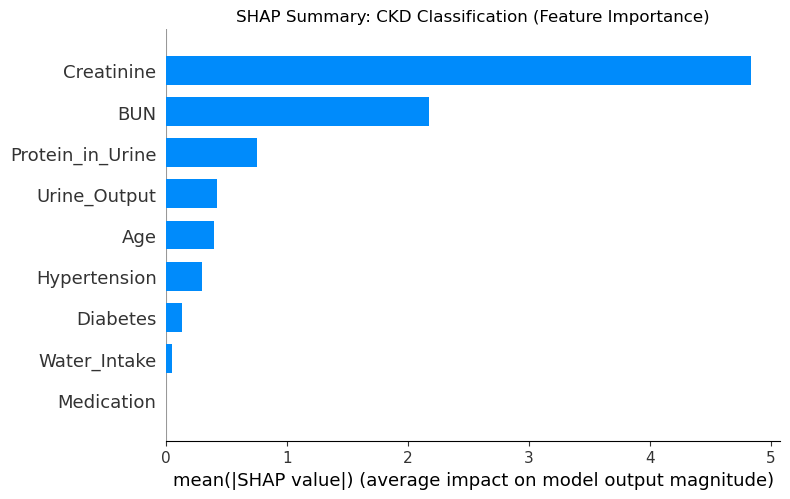

In [4]:
# SHAP for CKD Model
explainer_ckd = shap.TreeExplainer(model_ckd)
shap_values_ckd = explainer_ckd.shap_values(X_test)

plt.figure(figsize=(10, 6))
plt.title("SHAP Summary: CKD Classification (Feature Importance)")
# X_test is cuDF, convert to pandas for SHAP plotting compatibility
shap.summary_plot(shap_values_ckd, X_test.to_pandas(), plot_type="bar")
plt.show()

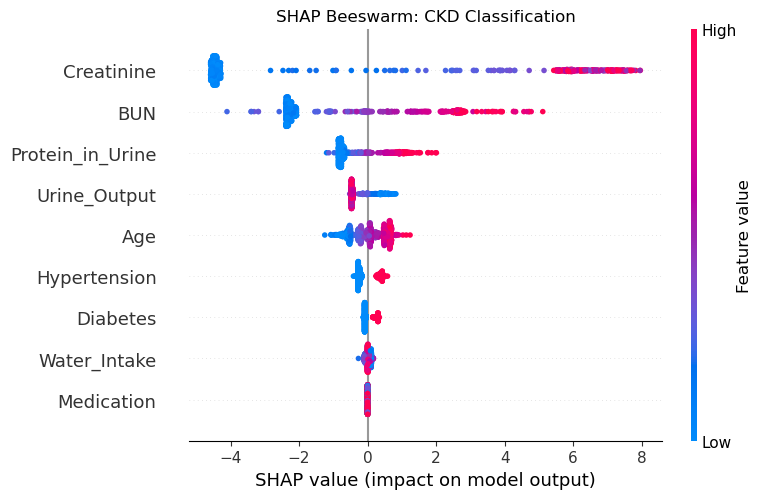

In [5]:
plt.figure(figsize=(10, 6))
plt.title("SHAP Beeswarm: CKD Classification")
shap.summary_plot(shap_values_ckd, X_test.to_pandas())
plt.show()

## 4. Analysis: GFR Regressor

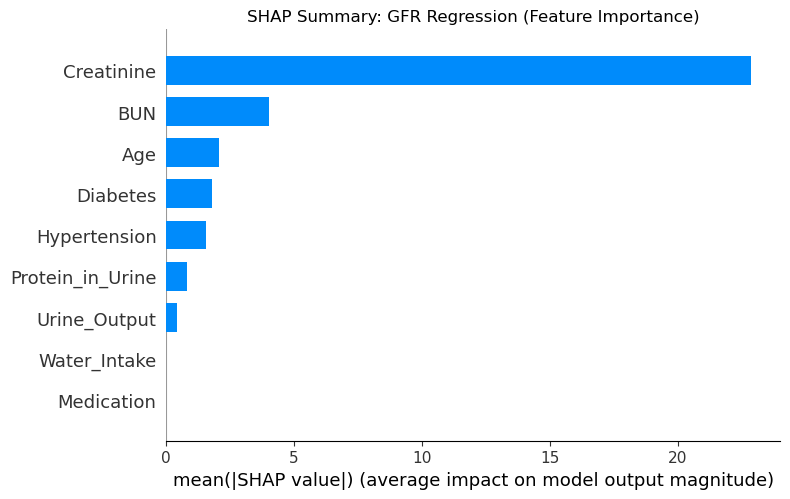

In [6]:
# SHAP for GFR Model
explainer_gfr = shap.TreeExplainer(model_gfr)
shap_values_gfr = explainer_gfr.shap_values(X_test)

plt.figure(figsize=(10, 6))
plt.title("SHAP Summary: GFR Regression (Feature Importance)")
shap.summary_plot(shap_values_gfr, X_test.to_pandas(), plot_type="bar")
plt.show()

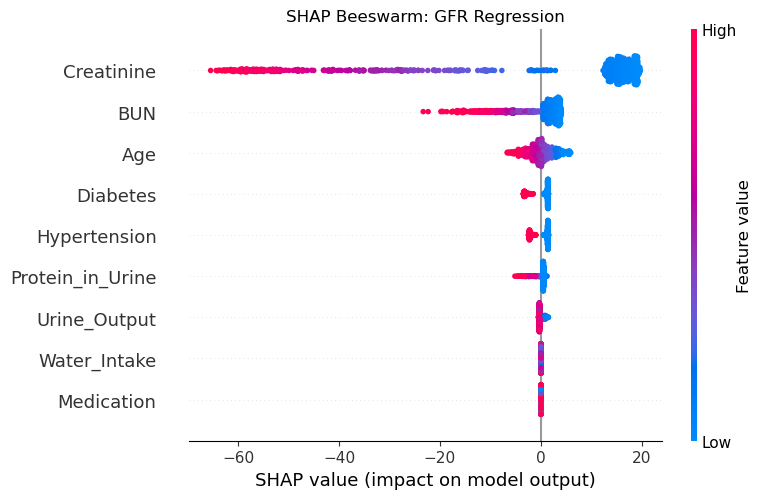

In [7]:
plt.figure(figsize=(10, 6))
plt.title("SHAP Beeswarm: GFR Regression")
shap.summary_plot(shap_values_gfr, X_test.to_pandas())
plt.show()

### Actual vs Predicted (GFR)

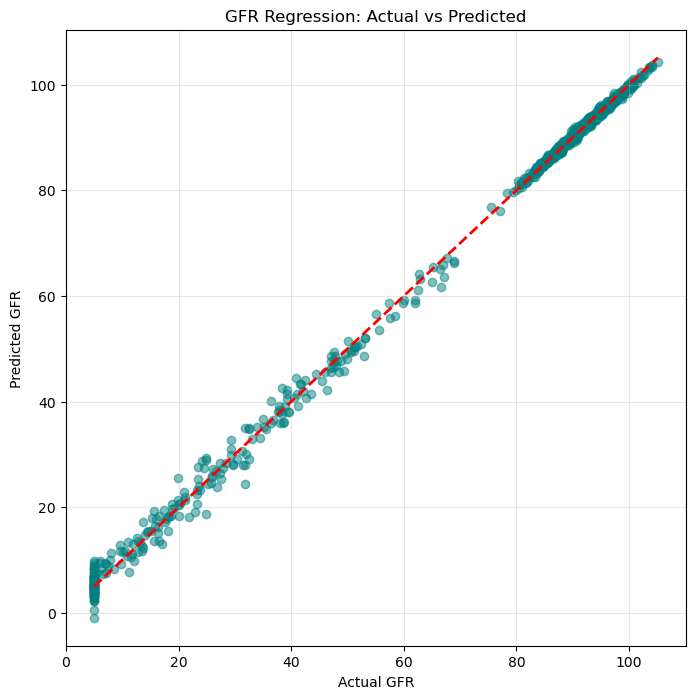

In [8]:
dtest = xgb.DMatrix(X_test)
preds_gfr = model_gfr.predict(dtest)
actual_gfr = y_gfr_test.to_numpy()

plt.figure(figsize=(8, 8))
plt.scatter(actual_gfr, preds_gfr, alpha=0.5, color='teal')
plt.plot([actual_gfr.min(), actual_gfr.max()], [actual_gfr.min(), actual_gfr.max()], 'r--', lw=2)
plt.xlabel("Actual GFR")
plt.ylabel("Predicted GFR")
plt.title("GFR Regression: Actual vs Predicted")
plt.grid(True, alpha=0.3)
plt.show()